::::
:::{thebe-button}
:::
::::

# Fit tracks

Compare experimental bubble histories to bubble history correlations. Bubble detection and linking performed by Trackpy, an implementation of the Crocker-Grier algorithm {cite}`allanTrackpy2018,crockerMethodsDigitalVideo1996`.


In [1]:
from boilercv_docs.nbs import init

paths = init()
from inspect import Signature

from boilercore.fits import fit_from_params
from boilercore.models.fit import Fit, get_model_errors
from matplotlib.figure import Figure
from matplotlib.pyplot import subplot_mosaic, subplots
from numpy import diff, gradient, log10, logspace, pi
from pandas import DataFrame, Series, melt, read_hdf
from seaborn import lineplot, move_legend, scatterplot

from boilercv.correlations import GROUPS, INDEPENDENT_VARIABLES, SYMBOL_LABELS, beta
from boilercv.correlations import nusselt as correlations_nusselt
from boilercv.dimensionless_params import (
    fourier,
    jakob,
    kinematic_viscosity,
    nusselt,
    prandtl,
    reynolds,
    thermal_diffusivity,
)
from boilercv.images import scale_bool
from boilercv_docs.nbs import HIDE
from boilercv_pipeline.experiments.e230920_subcool import (
    GBC,
    M_TO_MM,
    OBJECTS,
    THERMAL_DATA,
    TRACKS,
    Col,
    get_cat_colorbar,
    plot_composite_da,
    transform_cols,
)
from boilercv_pipeline.experiments.e240215_plotting import cat10, cool
from boilercv_pipeline.sets import get_dataset

S = Series

TIME = "2023-09-20T17:14:18"
"""Timestamp of the trial to be analyzed."""
FIGURES: list[Figure] = []
"""Notebook figures available for export."""

# Track tuning
INITIAL_FRAMES = 50
"""Initial frames to average."""
YPX_SURFACE_THRESHOLD = 400
"""Vertical position of bubble centroids considered attached to the surface."""
YPX_DEPARTURE_THRESHOLD = 420
"""Vertical position of bubble centroids considered to have departed the surface."""
MINIMUM_LIFETIME = 0.010  # (s)
"""Minimum bubble lifetime to consider."""

# Physical parameters
LATENT_HEAT_OF_VAPORIZATION = 2.23e6  # J/kg
LIQUID_DENSITY = 960  # kg/m^3
LIQUID_DYNAMIC_VISCOSITY = 2.88e-4  # Pa-s
LIQUID_ISOBARIC_SPECIFIC_HEAT = 4213  # J/kg-K
LIQUID_THERMAL_CONDUCTIVITY = 0.676  # W/m-K
VAPOR_DENSITY = 0.804  # kg/m^3

# Plotting
FRAME_INTERVAL = 50
"""Frame interval for plotting."""
CORRELATIONS_PALETTE = cat10
"""For plotting one approach."""
TRACKS_PALETTE = cool
"""For plotting the other approach."""
MAX_FOURIER = 0.01
"""Maximum Fourier number to plot."""
MAX_BETA = 1.05
"""Maximum dimensionless bubble diameter to plot."""
MAX_NUSSELT = 500
"""Maximum Nusselt number to plot."""
TRACKS_ALPHA = 0.3
"""Transparency of the tracks."""
TRACKS_SIZE = 10
"""Size of the tracks."""

HIDE

In [2]:
path_time = TIME.replace(":", "-")
video = scale_bool(
    get_dataset(path_time, stage="filled", frame=slice(0, None, FRAME_INTERVAL))[
        "video"
    ]
)
frametime = diff(video.time.values).mean() / FRAME_INTERVAL
objects: DataFrame = read_hdf((OBJECTS / f"objects_{path_time}").with_suffix(".h5"))  # pyright: ignore[reportAssignmentType]
thermal_data = read_hdf(THERMAL_DATA)
subcooling = thermal_data.subcool[TIME]
minimum_frame_lifetime = int(MINIMUM_LIFETIME // frametime)
raw_tracks: DataFrame = read_hdf((TRACKS / f"tracks_{path_time}").with_suffix(".h5"))  # pyright: ignore[reportAssignmentType]


def get_init(ser: S) -> float:
    """Get initial value of a series."""
    return ser.head(minimum_frame_lifetime).mean()


HIDE

## History of long-lived bubbles

The paths taken by long-lived bubbles are shown in **Figure&NonBreakingSpace;2**. Two active nucleation sites are responsible for all bubbles produced, and bubbles departing from each nucleation site take one of a few predominant paths during the short period of observation.


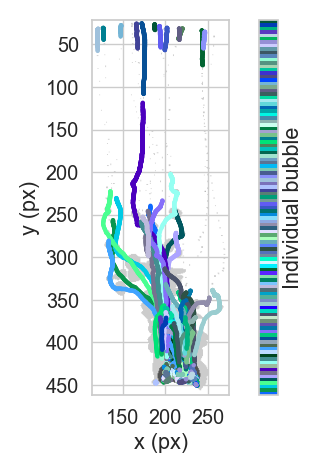

In [3]:
figure, ax = subplots()
FIGURES.append(figure)
plot_composite_da(video, ax)
long_lived_objects = raw_tracks.query(f"frame_lifetime > {minimum_frame_lifetime}")
N = long_lived_objects["bubble"].nunique()
palette, tracks_data = get_cat_colorbar(
    ax,
    palette=TRACKS_PALETTE,
    data=long_lived_objects.pipe(
        transform_cols,
        [
            hue := Col("bubble", "Individual bubble"),
            x := Col("x_px", "x", "px"),
            y := Col("y_px", "y", "px"),
        ],
    ),
    col=hue.new,
)
scatterplot(
    ax=ax,
    edgecolor="none",
    s=10,
    x=x.new,
    y=y.new,
    hue=hue.new,
    legend=False,
    palette=palette,
    data=tracks_data,
)

HIDE

**Figure&NonBreakingSpace;1**: Long-lived bubble tracks  
Bubble tracks indicated by the positions of detected centroids over time.

## Aligning bubble departures

Exclude bubbles that did not originate from the boiling surface, or that had already departed the surface at the time of recording. Consider a bubble to have departed the surface when its centroid crosses a departure threshold which is about one average bubble diameter above the boiling surface. Define the origin for time of departure for each bubble in this fashion. The resulting time history in **Figure&NonBreakingSpace;2** shows bubble depth, velocity, and diameter for the remainder of its visible lifetime.

Most bubbles rise and collapse at similar rates. Two bubbles rise slower than the rest, but seem to collapse at about the same rate as others.


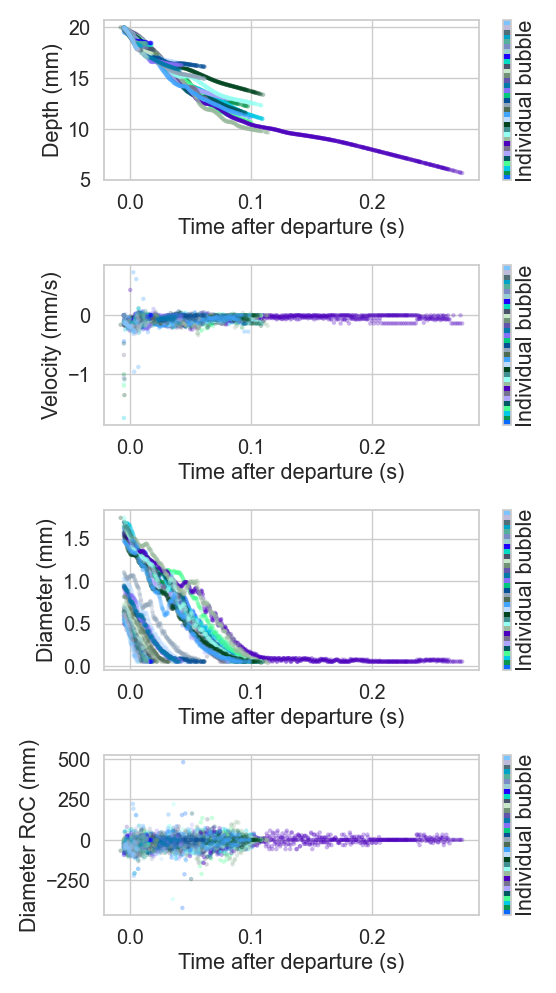

In [4]:
departing_long_lived_objects = (
    # Find rows corresponding to stagnant or invalid bubbles
    long_lived_objects.groupby("bubble", **GBC)
    .apply(
        # Don't assign any other columns until invalid rows have been filtered out
        lambda df: df.assign(
            yinit_px=lambda df: df["y_px"].pipe(get_init),
            # Initial y position is close to the surface
            began=lambda df: df["yinit_px"] > YPX_SURFACE_THRESHOLD,
            # When the bubble gets far enough away from the surface
            departed=lambda df: df["y_px"] < YPX_DEPARTURE_THRESHOLD,
        )
    )
    # Filter out invalid rows and drop the columns used to determine validity
    .pipe(lambda df: df[df["began"] & df["departed"]])
    .drop(columns=["began", "departed"])
    # Groupby again after filtering out invalid rows
    .groupby("bubble", **GBC)
    # Now columns that depend on the initial row (*.iat[0]) can be assigned
    .apply(
        lambda df: df.assign(
            frame=lambda df: df["frame"] - df["frame"].pipe(get_init),
            time=lambda df: df["time"] - df["time"].pipe(get_init),
            frame_lifetime=lambda df: df["frame"].iat[-1] - df["frame"].pipe(get_init),
            lifetime=lambda df: df["frame_lifetime"] * frametime,
            y_init=lambda df: df["y"].pipe(get_init),
            x_init=lambda df: df["x"].pipe(get_init),
            init_diameter=lambda df: df["diameter"].pipe(get_init),
            dy_init=lambda df: df["dy"].pipe(get_init),
            dy_init_px=lambda df: df["dy"].pipe(get_init),
            max_diameter=lambda df: df["diameter"].max(),
            diameter_rate_of_change=lambda df: gradient(df["diameter"], df["time"]),
        )
    )
)
cols = [
    hue := Col("bubble", "Individual bubble"),
    x := Col("time", "Time after departure", "s"),
    y := Col("y", "Depth", **M_TO_MM),
    v := Col("dy", "Velocity", "m/s", "mm/s"),
    d := Col("diameter", "Diameter", **M_TO_MM),
    dg := Col("diameter_rate_of_change", "Diameter RoC", **M_TO_MM),
]
figure, axs = subplot_mosaic([[y.new], [v.new], [d.new], [dg.new]])
FIGURES.append(figure)
figure.set_size_inches(6, 10)
for plot, ax in axs.items():
    palette, tracks_data = get_cat_colorbar(
        ax,
        hue.new,
        TRACKS_PALETTE,
        departing_long_lived_objects.pipe(transform_cols, cols),
    )
    scatterplot(
        ax=ax,
        edgecolor="none",
        s=TRACKS_SIZE,
        alpha=TRACKS_ALPHA,
        x=x.new,
        y=plot,  # pyright: ignore[reportArgumentType] 1.1.356
        hue=hue.new,
        legend=False,
        palette=palette,
        data=tracks_data,
    )

**Figure&NonBreakingSpace;2**: Time history of long-lived bubbles Bubble depth, velocity, and diameter plotted over time.

Histograms of individual bubble statistics are shown in **Figure&NonBreakingSpace;3**. Because no bubbles completely collapse, bubble lifetimes correspond to the duration of time between their departure from the boiling surface and rising past the upper limit of the camera viewpoint. The maximum bubble diameter is about 3&NonBreakingSpace;mm.

The bimodal distribution of initial $x$ positions is also evident, corresponding to two active nucleation sites. Initial bubble velocity at departure tends to be about 250&NonBreakingSpace;mm/s.


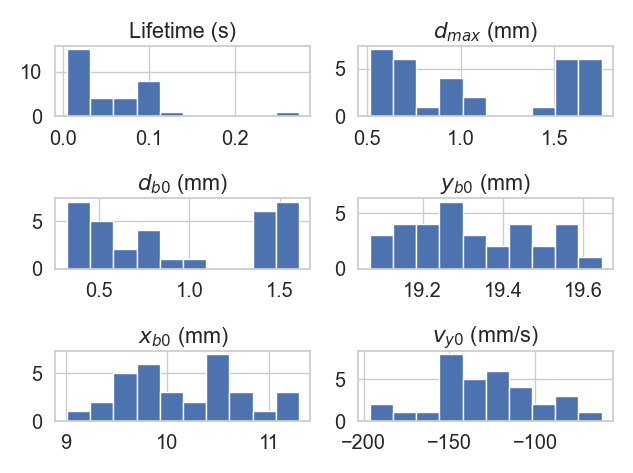

In [5]:
liquid_thermal_diffusivity = thermal_diffusivity(
    thermal_conductivity=LIQUID_THERMAL_CONDUCTIVITY,
    density=LIQUID_DENSITY,
    isobaric_specific_heat=LIQUID_ISOBARIC_SPECIFIC_HEAT,
)
liquid_kinematic_viscosity = kinematic_viscosity(
    density=LIQUID_DENSITY, dynamic_viscosity=LIQUID_DYNAMIC_VISCOSITY
)
tracks = departing_long_lived_objects.assign(**{
    "reynolds": lambda df: reynolds(
        velocity=abs(df["dy"]),
        characteristic_length=df["diameter"],
        kinematic_viscosity=liquid_kinematic_viscosity,
    ),
    "Bubble Fourier number": fourier(
        initial_bubble_diameter=departing_long_lived_objects["init_diameter"],
        liquid_thermal_diffusivity=liquid_thermal_diffusivity,
        time=departing_long_lived_objects["time"],
    ),
    "Nusselt number": nusselt(
        heat_transfer_coefficient=-(
            2
            * VAPOR_DENSITY
            * LATENT_HEAT_OF_VAPORIZATION
            / subcooling
            * departing_long_lived_objects["diameter_rate_of_change"]
        ),
        characteristic_length=departing_long_lived_objects["diameter"],
        thermal_conductivity=LIQUID_THERMAL_CONDUCTIVITY,
    ),
    "Dimensionless bubble diameter": (lambda df: df["diameter"] / df["init_diameter"]),
})
figure, ax = subplots()
FIGURES.append(figure)
(
    tracks.pipe(
        transform_cols,
        [
            Col("bubble"),
            Col("lifetime", "Lifetime", "s"),
            Col("max_diameter", r"$d_{max}$", **M_TO_MM),
            Col("init_diameter", r"$d_{b0}$", **M_TO_MM),
            Col("y_init", r"$y_{b0}$", **M_TO_MM),
            Col("x_init", r"$x_{b0}$", **M_TO_MM),
            Col("dy_init", r"$v_{y0}$", old_unit="m/s", new_unit="mm/s", scale=1000),
        ],
    )
    .groupby("bubble", **GBC)
    .mean()
    .set_index("bubble")
    .hist(ax=ax)
)

HIDE

**Figure&NonBreakingSpace;3**: Histograms of individual bubble statistics  
Shows bubble lifetime, maximum diameter, and bubble properties at departure.


# Correlations

See {eq}`eq_beta_florschuetz_chao_1965` and {eq}`eq_beta_yuan_et_al_2009`.

In [6]:
object_averages = (
    departing_long_lived_objects.set_index("bubble")
    .groupby("bubble", **GBC)
    .mean()
    .mean()
)
bubble_initial_reynolds = reynolds(
    velocity=abs(object_averages["dy_init"]),
    characteristic_length=object_averages["init_diameter"],
    kinematic_viscosity=liquid_kinematic_viscosity,
)
liquid_prandtl = prandtl(
    dynamic_viscosity=LIQUID_DYNAMIC_VISCOSITY,
    isobaric_specific_heat=LIQUID_ISOBARIC_SPECIFIC_HEAT,
    thermal_conductivity=LIQUID_THERMAL_CONDUCTIVITY,
)
bubble_jakob = jakob(
    liquid_density=LIQUID_DENSITY,
    vapor_density=VAPOR_DENSITY,
    liquid_isobaric_specific_heat=LIQUID_ISOBARIC_SPECIFIC_HEAT,
    subcooling=subcooling,
    latent_heat_of_vaporization=LATENT_HEAT_OF_VAPORIZATION,
)
bubble_fourier_smooth = logspace(
    stop=log10(MAX_FOURIER), start=log10(MAX_FOURIER) - 4, num=int(1e4)
)
beta_correlations = beta.get_correlations()
nusselt_correlations = correlations_nusselt.get_correlations()
constants = {
    "Fo_0": bubble_fourier_smooth,
    "Ja": bubble_jakob,
    "Re_b0": bubble_initial_reynolds,
    "Pr": liquid_prandtl,
    "alpha": liquid_thermal_diffusivity,
    "pi": pi,
}

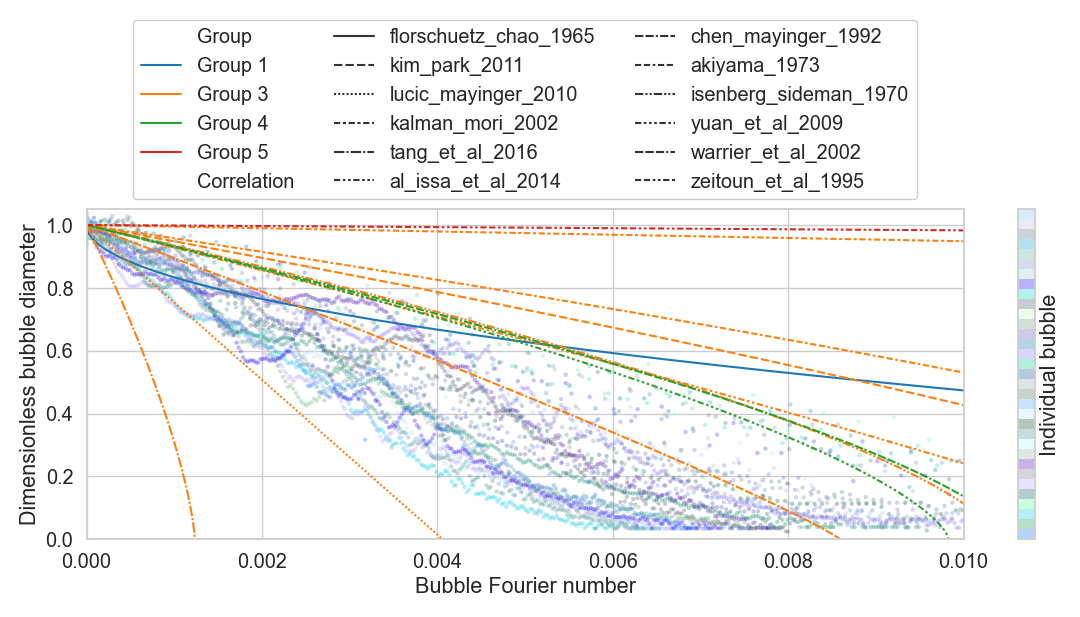

In [7]:
beta_empirical = DataFrame(index=bubble_fourier_smooth).assign(**{
    label: corr.expr(**{
        kwd: value
        for kwd, value in constants.items()
        if kwd in Signature.from_callable(corr.expr).parameters
    })
    for label, corr in beta_correlations.items()
})
beta_empirical_pivoted = (
    melt(
        beta_empirical.where(lambda s: s > 0.0),
        value_vars=list(beta_correlations.keys()),
        var_name="Correlation",
        ignore_index=False,
    )
    .assign(**{
        "Bubble Fourier number": lambda df: df.index,
        "Dimensionless bubble diameter": lambda df: df["value"],
        "Group": lambda df: df["Correlation"].map(GROUPS),
    })
    .reset_index(drop=True)
).sort_values("Group")
figure, ax = subplots()
FIGURES.append(figure)
ax.set_xlim(0, MAX_FOURIER)
ax.set_ylim(0, MAX_BETA)
# ax.plot(label=f"{subcooling:.2f} K")
lineplot(
    ax=ax,
    x="Bubble Fourier number",
    y="Dimensionless bubble diameter",
    data=beta_empirical_pivoted,
    style="Correlation",
    hue="Group",
    palette=CORRELATIONS_PALETTE,
)
move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1), ncol=3)
palette, tracks_data = get_cat_colorbar(
    ax,
    palette=TRACKS_PALETTE,
    data=tracks.pipe(
        transform_cols,
        [
            hue := Col("bubble", "Individual bubble"),
            x := Col("Bubble Fourier number"),
            y := Col("Dimensionless bubble diameter"),
        ],
    ),
    col=hue.new,
    alpha=TRACKS_ALPHA,
)
scatterplot(
    ax=ax,
    s=TRACKS_SIZE,
    alpha=TRACKS_ALPHA,
    x=x.new,
    y=y.new,
    hue=hue.new,
    palette=TRACKS_PALETTE,
    legend=False,
    data=tracks_data,
)
figure.set_figwidth(1.89 * figure.get_figwidth())
figure.set_figheight(1.30 * figure.get_figheight())
HIDE

**Figure&NonBreakingSpace;5**: Comparison of bubble histories to correlations

Two correlations are shown. The early bubble history follows that of the analytical correlation by Florshuetz and Chao (1965), while the late bubble history follows that of Yuan et al (2009).


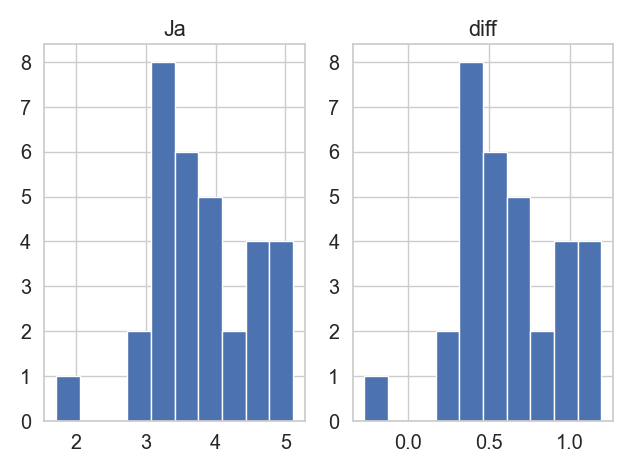

In [8]:
def fit_jakob_to_florschuetz_chao_1965(track: DataFrame):
    """Get Jakob number."""
    expr = beta_correlations["florschuetz_chao_1965"].expr
    model_params = [
        p
        for p in Signature.from_callable(expr).parameters
        if p not in INDEPENDENT_VARIABLES
    ]
    fixed_params = ["pi"]
    free_params = [p for p in model_params if p not in fixed_params]
    model_errors = get_model_errors(model_params)
    fits, _errors = fit_from_params(
        model=expr,
        params=Fit(
            model_params=model_params,  # pyright: ignore[reportCallIssue]
            fixed_params=fixed_params,  # pyright: ignore[reportCallIssue]
            free_params=free_params,  # pyright: ignore[reportCallIssue]
            free_errors=get_model_errors(free_params),  # pyright: ignore[reportCallIssue]
            model_errors=model_errors,  # pyright: ignore[reportCallIssue]
            fixed_errors=get_model_errors(fixed_params),  # pyright: ignore[reportCallIssue]
            params_and_errors=[*model_params, *model_errors],  # pyright: ignore[reportCallIssue]
            model_inputs={
                p: v for p, v in constants.items() if p not in INDEPENDENT_VARIABLES
            },
            model_bounds={"Ja": (0, "inf"), "pi": (0, "inf")},
            initial_values={p: v for p, v in constants.items() if p in model_params},
        ),
        x=track.loc[:, "Fo_0"].values,
        y=track.loc[:, "beta"].values,
    )
    return fits["Ja"]


DataFrame(
    (
        tracks.rename(columns={v: k for k, v in SYMBOL_LABELS.items()})
        .loc[:, ["bubble", "beta", "Fo_0"]]
        .pipe(lambda df: df[(df > 0).all(axis="columns")])
    )
    .set_index("bubble")
    .groupby(level="bubble", sort=False, group_keys=False)
    .apply(fit_jakob_to_florschuetz_chao_1965)
    .rename("Ja")
).assign(**{"diff": lambda df: (df["Ja"] - bubble_jakob) / bubble_jakob}).hist()

HIDE